In [1]:
import os
os.chdir("../")

overwrite = False
dataset_name = 'nicu'
attr_suffix = ''
suffix = '_brady2' 

# Data

In [2]:
with open('run/settings.py', 'r') as file:
    exec(file.read())
# with open('run/data.py', 'r') as file:
#     exec(file.read())
model_name = ''.join([dataset_name, attr_suffix, suffix]) 
exec(open('run/configs/nicu_brady2.py', 'r').read())
if attr_suffix == '':
    config_dict = update_config(config_dict, custom_target_cols = ['label'])
if 'open_vocab' in locals():
    config_dict = update_config(config_dict, open_vocab = open_vocab)
exec(open('run/prepare_datasets/nicu.py', 'r').read())
with open('run/inputs.py', 'r') as file:
    exec(file.read())

Random seed set to 333
using device:  cpu
nicu_brady2
nicu_brady2

Sample of patients with positive labels:
VitalID
1018    8
5170    8
1835    8
2361    8
2791    8
dtype: int64


Processing descriptions: 100%|██████████| 131/131 [00:27<00:00,  4.79it/s]


After downsampling:
description_ts_event_binary
No events.                      20000
Bradycardia events happened.     3610
Name: count, dtype: int64
train, test, left:  16527 4722 2361


final distribution of text prediction
description_ts_event_binary
No events.                      14000
Bradycardia events happened.     2527
Name: count, dtype: int64
description_ts_event_binary
No events.                      4000
Bradycardia events happened.     722
Name: count, dtype: int64
description_ts_event_binary
No events.                      2000
Bradycardia events happened.     361
Name: count, dtype: int64
text
No events.                      14000
Bradycardia events happened.     2527
Name: count, dtype: int64
text
No events.                      4000
Bradycardia events happened.     722
Name: count, dtype: int64
text
No events.                      2000
Bradycardia events happened.     361
Name: count, dtype: int64
nicu_brady2
standardization mean and std:  150.08409565492155 20.041058

# Model (customizable)

In [3]:
with open('run/model.py', 'r') as file:
    exec(file.read())

nicu_brady2
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/script/VITAL/results/nicu_brady2
nicu_brady2
Layer (type:depth-idx)                                                 Param #
VITAL                                                                  --
├─TSEncoder: 1-1                                                       --
│    └─LocalNorm: 2-1                                                  --
│    └─PatchCNNTSEncoder: 2-2                                          --
│    │    └─ModuleList: 3-1                                            1,859,424
│    │    └─LayerNorm: 3-2                                             1,536
├─TextEncoder: 1-2                                                     --
│    └─PatchMLPTextEncoder: 2-3                                        --
│    │    └─ModuleList: 3-3                                            5,327,616
├─TSDecoder: 1-3                                                       --
│    └─SelfAttnDec

In [4]:
# with open('run/train_2steps.py', 'r') as file:
#     exec(file.read())

# Generation

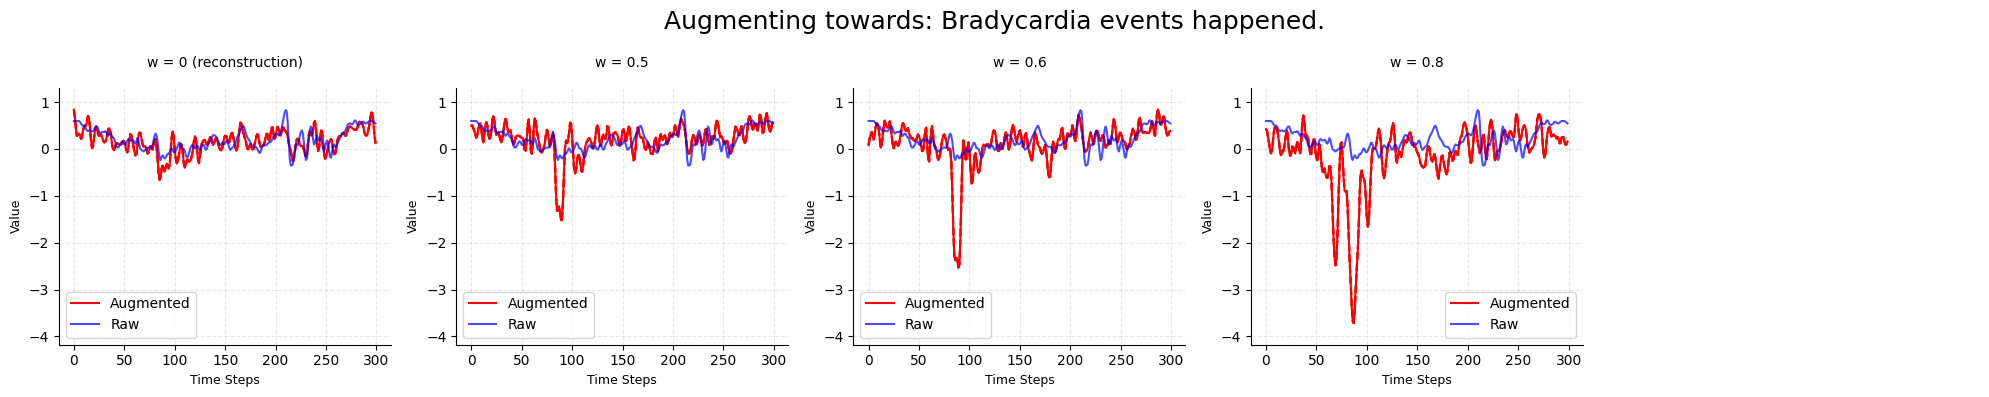

In [5]:

# tid=0
# viz_generation_conditional(df_train, model, config_dict, tid=tid, sampling=True, b=1, ep=1)

tid = 0
df = df_train

model.eval()

w_values = [0, 0.5, 0.6, 0.8]
y_col = 'description_ts_event_binary'
ref_level = 'No events.'
tgt_level = 'Bradycardia events happened.'

df_level = df[df[y_col] == ref_level].reset_index(drop=True).iloc[[tid]].copy()
df_level['new_text'] = df_level['text'].str.replace(ref_level, tgt_level)
essentials = plot_interpolate_ts_tx_ws_sampling(df_level, model, config_dict, text_cols=['new_text'], w_values = w_values, label = True, b=1, ep=1, ylims = None, return_essentials = True)



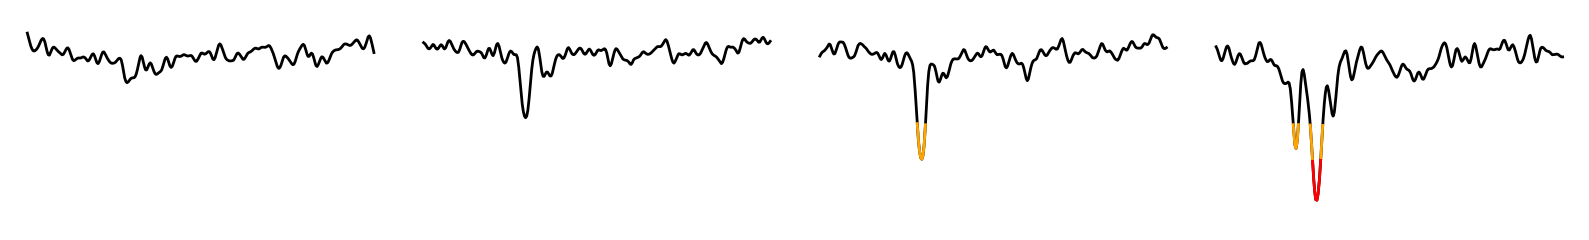

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------------------
raw_ts   = essentials["raw_ts"]
medians  = essentials["median"]
w_values = essentials["w_values"]
text_cond = tgt_level
# --------------------------------------------------------------------------

MEAN, SD = 130, 20
rescale  = lambda a: a * SD + MEAN

ORANGE_THR = 99.5
RED_THR    =  80

def movavg(x, k=3):
    pad = k // 2
    x_pad = np.pad(x, (pad, pad), mode="edge")
    return np.convolve(x_pad, np.ones(k) / k, mode="valid")

# -------- y-limits (unchanged) ---------------------------------------------
all_vals = [rescale(medians[text_cond][float(w)]) for w in w_values]
gmin, gmax = min(v.min() for v in all_vals), max(v.max() for v in all_vals)
ylims = (gmin - 0.1 * (gmax - gmin), gmax + 0.1 * (gmax - gmin))

# -------- reference, then interpolate to 600 pts ---------------------------
ref_q50 = movavg(rescale(medians[text_cond][0.0]), k=3)
orig_len = len(ref_q50)
t_orig = np.arange(orig_len)
t_new  = np.linspace(0, orig_len - 1, 2400)          # <<< INTERPOLATE >>>
ref_q50 = np.interp(t_new, t_orig, ref_q50)         # <<< INTERPOLATE >>>

# -------- grid -------------------------------------------------------------
n_cols = 4
n_rows = int(np.ceil(len(w_values) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2.5))
axs = axs.ravel()

for idx, w in enumerate(w_values):
    ax = axs[idx]

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # if w != 0:
    #     ax.plot(x, ref_q50, color="black", linestyle="--", linewidth=1)

    # masks
    mask_red  = q50 <= RED_THR
    mask_red  |= np.roll(mask_red,  1) | np.roll(mask_red, -1)
    mask_orange = (q50 <= ORANGE_THR) & ~mask_red

    # baseline
    ax.plot(x, q50, color="black", linewidth=2) #cornflowerblue
    # overlays
    ax.plot(x, np.ma.masked_where(~mask_orange, q50),
            color="orange", linewidth=2)
    ax.plot(x, np.ma.masked_where(~mask_red, q50),
            color="red",    linewidth=2)

    ax.set_ylim(*ylims)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])  # Remove x ticks
    ax.set_yticks([])  # Remove x ticks
    ax.set_xticklabels([])  # Remove x tick labels
    ax.set_yticklabels([])  # Remove x tick labels
    ax.axis('off') 

# hide empties
for idx in range(len(w_values), n_rows * n_cols):
    axs[idx].axis("off")

plt.tight_layout()
plt.show()


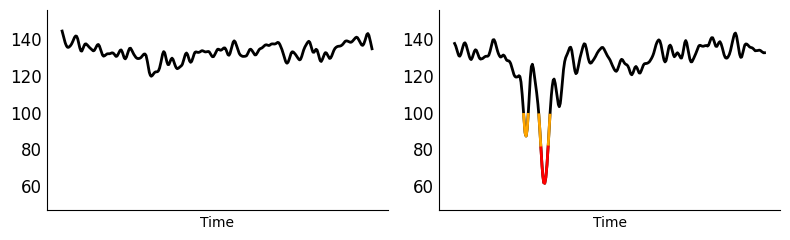

In [7]:
# -------- grid -------------------------------------------------------------
n_cols = 2  # Changed from 4 to 2
n_rows = 1  # Changed to 1 since we only want 2 plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2.5))
axs = axs.ravel()

# Only plot first and last w_values
w_values_to_plot = [w_values[0], w_values[-1]]  # First and last values

for idx, w in enumerate(w_values_to_plot):
    ax = axs[idx]

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # if w != 0:
    #     ax.plot(x, ref_q50, color="black", linestyle="--", linewidth=1)

    # masks
    mask_red  = q50 <= RED_THR
    mask_red  |= np.roll(mask_red,  1) | np.roll(mask_red, -1)
    mask_orange = (q50 <= ORANGE_THR) & ~mask_red

    # baseline
    ax.plot(x, q50, color="black", linewidth=2) # cornflowerblue, dimgray
    # overlays
    ax.plot(x, np.ma.masked_where(~mask_orange, q50),
            color="orange", linewidth=2)
    ax.plot(x, np.ma.masked_where(~mask_red, q50),
            color="red",    linewidth=2)

    ax.set_ylim(*ylims)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])  # Remove x ticks
    ax.set_xticklabels([])  # Remove x tick labels
    ax.tick_params(axis='y', labelsize=12)  # Smaller y tick font
    ax.tick_params(axis='both', length=0)  # Remove tick marks (sticks)
    ax.set_xlabel("Time")  # Add xlabel
plt.tight_layout()
plt.show()

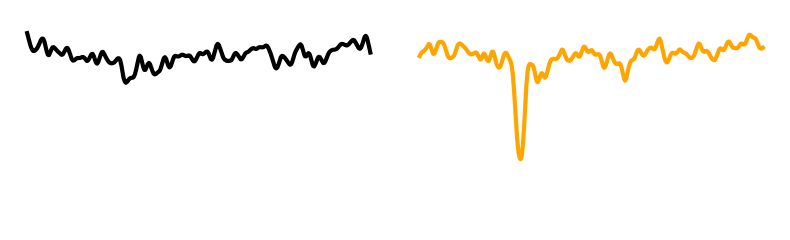

In [8]:
# -------- grid -------------------------------------------------------------
n_cols = 2  # Changed from 4 to 2
n_rows = 1  # Changed to 1 since we only want 2 plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2.5))
axs = axs.ravel()

# Only plot first and last w_values
w_values_to_plot = [w_values[0], w_values[-2]]  # First and last values

for idx, w in enumerate(w_values_to_plot):
    ax = axs[idx]

    q50 = movavg(rescale(medians[text_cond][float(w)]), k=5)
    q50 = np.interp(t_new, t_orig, q50)             # <<< INTERPOLATE >>>
    x   = t_new                                     # new 600-point axis

    # if w != 0:
    #     ax.plot(x, ref_q50, color="black", linestyle="--", linewidth=1)

    # masks
    mask_red  = q50 <= RED_THR
    mask_red  |= np.roll(mask_red,  1) | np.roll(mask_red, -1)
    mask_orange = (q50 <= ORANGE_THR) & ~mask_red

    # baseline
    if idx == 0:  # First plot - normal colors 
        ax.plot(x, q50, color="black", linewidth=3)#cornflowerblue
    else:  # Second plot - all orange
        ax.plot(x, q50, color="orange", linewidth=3)


    ax.set_ylim(*ylims)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])  # Remove x ticks
    ax.set_xticklabels([])  # Remove x tick labels
    ax.tick_params(axis='y', labelsize=12)  # Smaller y tick font
    ax.tick_params(axis='both', length=0)  # Remove tick marks (sticks)
    ax.set_xlabel("Time")  # Add xlabel
    ax.axis('off') 

plt.tight_layout()
plt.show()

In [9]:
# tid=1
# viz_generation_conditional(df_left, model, config_dict, tid=tid, sampling=True, b=1, ep=1)